# Earth System Data Lab Exercise - EO Summer School 2018

# Exercise3: Calculate the correlation between variables in the cube

### earthsystemdatalab.net (provided by: MPI-BGC Jena & Brockman Consult GmbH)

The task we try to solve here

* 1st: Understand how two time series (e.g. surface moisture and VPD) are related
* 2nd: Understand "co-relation" between two variables

In both cases we aim to inspect these relations within a region, then aggregated by region.

Steps:
* Define a function to calculate correlation between two variables
* Define a function to calculate correlation with more robust estimators as proposed by Shevlyakov & Smirnov
* Select two variables and calculate a correlation of those two variables.
* See the discrepancies between the correlations resulted from the two functions
* Do the first four steps, but this time for each pixel instead of aggregated by region

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from ipywidgets import interact, fixed
import warnings
warnings.filterwarnings('ignore')

### Open Country Cube and create functions to display it

Country Cube is a cube data that is created to enable country based analysis. It was created by using the country mask in ESDC and average the rest of the variables for each country. In addition to that, some socio-economic data from WorldBank is also added to this cube. In total, there are 1474 variables to choose from. Let's see if we can do anything interesting with this cube.

First create a function to display a variable from this cube. Basemap is a great library to display raster data in different projections. We will try three different projections. 

Basemap: http://basemaptutorial.readthedocs.io/en/latest/<br>
Basemap projections: https://matplotlib.org/basemap/users/mapsetup.html

In [2]:
MERCATOR_PROJECTION = dict(projection='merc',llcrnrlat=-60,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
ECKERT4_PROJECTION = dict(projection='eck4',lon_0=0,resolution='c')
KAVRAYSKIY7_PROJECTION = dict(projection = "kav7", lon_0=0., resolution=None)

And then, load country cube, ESDC cube, as well as the country code map. 

In [3]:
country_cube_dataset = xr.open_dataset("/home/jovyan/work/datacube/country-cube-0.1.0/country_cube.nc")
country_cube_array = country_cube_dataset.to_array(dim="Indicator_Codes")
ESDC = xr.open_zarr("/home/jovyan/work/datacube/esdc-8d-0.25deg-1x720x1440-1.0.1_1_zarr")
country_code_map = "/home/jovyan/work/datacube/country-cube-0.1.0/country-codes.csv"

The structure of Country Cube is different to ESDC cube. While plotting images in ESDC cube is very easy (with the help of xarray wrapper API), plotting Country Cube variable requires a bit more work. First create two functions **plot_single_variable_2d()** and **plot_2d()** to show an image of a single variable and andy given data array, respectively. 

In [4]:
def plot_single_variable_2d(variable_name='air_temperature_2m', year=2010, title= None, projection = KAVRAYSKIY7_PROJECTION, save_image = False, **kwargs):
    if not title:
        title = variable_name + ', ' + str(year)
    selected_var_array = country_cube_array.sel(Indicator_Codes = variable_name,Year=year)
    plot_2d(selected_var_array, title, proj = projection, save_me=save_image, **kwargs)

def plot_2d(selected_var_array, title, **kwargs):
    lons, lats = np.meshgrid(ESDC.country_mask.lon,ESDC.country_mask.lat)
    country_mask_2D = ESDC.country_mask[0].values
    water_mask_2D = ESDC.water_mask[0].values
    cdict = _read_ESDC_countrycodes(country_code_map)
    # reverse the key and value pair 
    idict = {v: k for k, v in cdict.items()}
    
    country_based_data_array = _expand_to_latlon(selected_var_array, country_mask_2D, idict)
    masked_country_data_array = np.ma.array(country_based_data_array, mask =np.isnan(country_based_data_array))
    
    vmin = kwargs["vmin"] if "vmin" in kwargs else None
    vmax = kwargs["vmax"] if "vmax" in kwargs else None
    colorbar_label = kwargs["colorbar_label"] if "colorbar_label" in kwargs else None
    proj = kwargs["proj"] if "proj" in kwargs else dict(projection = "kav7", lon_0=0., resolution=None)
        
    fig = plt.figure(figsize=(18,9))
    ax = fig.add_axes([0.05,0.05,0.9,0.9])
    m = Basemap(**proj)
    m.drawmapboundary(fill_color='0.3')
    ccmap = plt.cm.jet
    ccmap.set_bad("gray",1.)
    im = m.pcolormesh(lons,lats,masked_country_data_array,shading='flat',cmap=ccmap,latlon=True, vmin = vmin, vmax=vmax)
    #im2 = m.pcolormesh(lons,lats,nodata,shading='flat',cmap=plt.cm.gist_gray,latlon=True)
    m.drawparallels(np.arange(-90.,99.,30.))
    m.drawmeridians(np.arange(-180.,180.,60.))
    cb = m.colorbar(im,"bottom", size="5%", pad="2%")
    if colorbar_label:
        cb.ax.set_xlabel(colorbar_label)
    ax.set_title(title)
    if "save_me" in kwargs:
        if kwargs["save_me"] == True:
            plt.savefig(title[0:15] + '.png',dpi = 600)
    ESDC.close()
    return fig, ax, m

def _read_ESDC_countrycodes(country_code_map_csv, code_type = 'ISO3166-1-Alpha-3'):
    df = pd.read_csv(country_code_map_csv)
    cc_dict = df.set_index('ISO3166-1-numeric').to_dict()
    return cc_dict[code_type]

def _expand_to_latlon(var_array, country_mask_2D, idict):
    latlon_array = np.empty(country_mask_2D.shape)
    latlon_array.fill(np.nan)
    for country_array in var_array:
        country_code = str(country_array.Country_Codes.values)
        if country_code in idict:
            country_code_numeric = idict[country_code]
            ii = country_mask_2D == country_code_numeric
            latlon_array[ii] = country_array.values
    return latlon_array

Create lists of variable names and years to enable selection in when using *interact*

In [5]:
var_names = []
for var_name in country_cube_dataset.data_vars:
    var_names.append(var_name)
    
years = []
for year in country_cube_dataset.Year:
    years.append(year.values)

Now plot a single variable

In [6]:
interact(plot_single_variable_2d, variable_name=var_names, year=(np.min(years), np.max(years), 1), title=fixed(''), projection = fixed(MERCATOR_PROJECTION), save_image=fixed(False))

interactive(children=(Dropdown(description='variable_name', index=1445, options=('AG.AGR.TRAC.NO', 'AG.CON.FER…

<function __main__.plot_single_variable_2d(variable_name='air_temperature_2m', year=2010, title=None, projection={'projection': 'kav7', 'lon_0': 0.0, 'resolution': None}, save_image=False, **kwargs)>

### Calculate Correlation Coefficient between two variables

Create a function to calculate correlation coefficient based on this formula:

$corr_{(x,y)} = \frac{cov(x,y)}{\sigma_x \sigma_y}$

with

$cov_{(x,y)} = \frac{\sum_{i=1}^n (x_i - \overline{x})(y_i - \overline{y})}{(n-1)}$

In [7]:
def corr_coeff(variable1_name, variable2_name):
    variable1 = country_cube_array.sel(Indicator_Codes = variable1_name)
    variable2 = country_cube_array.sel(Indicator_Codes = variable2_name)
    cov = _get_covariance(variable1, variable2)
    variable1_std = variable1.std(dim="Year")
    variable2_std = variable2.std(dim="Year")
    return _get_corr_coeff(cov, variable1_std, variable2_std)

def _get_covariance(variable1_array, variable2_array):
    X = (variable1_array - variable1_array.mean(dim="Year", skipna=True))
    Y = (variable2_array - variable2_array.mean(dim="Year", skipna=True))
    xxyy = X * Y
    return xxyy.mean(dim="Year")

def _get_corr_coeff(cov, std1, std2):
    return cov / (std1 * std2)

In [8]:
air_temp_soil_moisture_corr = corr_coeff('air_temperature_2m', 'soil_moisture')

(<matplotlib.figure.Figure at 0x7f9dd3239198>,
 <mpl_toolkits.basemap.Basemap at 0x7f9d985fdf60>)

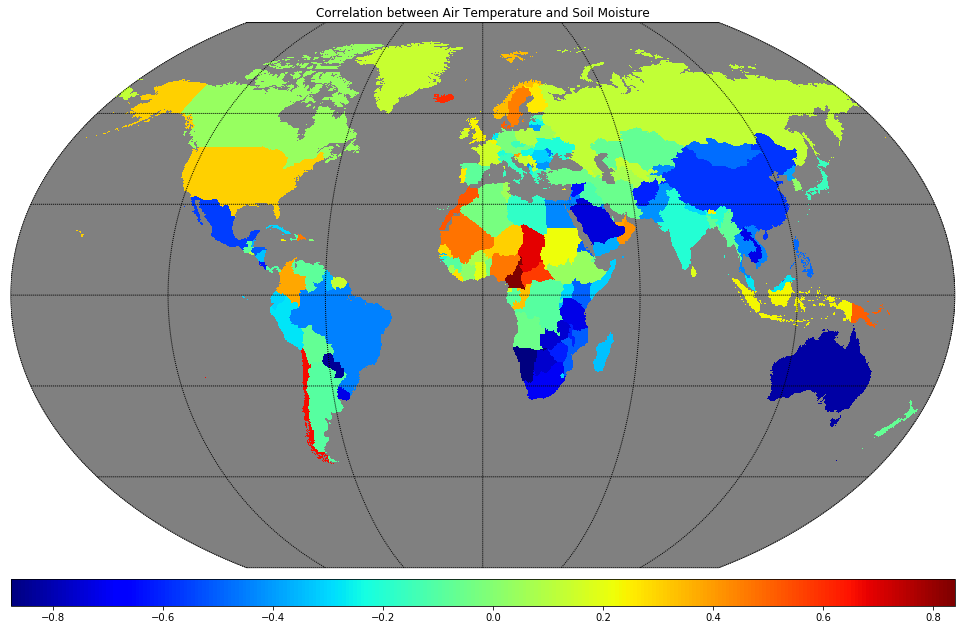

In [9]:
plot_2d(selected_var_array=air_temp_soil_moisture_corr, title='Correlation between Air Temperature and Soil Moisture')

### More robust calculation of Correlation Coefficient

We know that the classical correlation coefficient is sensitive. We may choose some robust alternative e.g. the $r_{COMED}$ proposed by Shevlyakov & Smirnov "Robust Estimation of the Correlation Coefficient: An Attempt of Survey", Austrian Journal of Statistics, 40, 147-156

$r_{COMED} = \frac{med((x-med(x))(y-med(y)))}{MAD(x)MAD(y)}$

where

* $med(x)$ is the median of x
* $MAD(x) = med(|x-med(x)|)$ is the median absolute deviation

Try to implement this yourself!

You can start by creating a function just like in the previous example. 

Hints:
* **xarray.Dataset.sel()**: http://xarray.pydata.org/en/stable/generated/xarray.Dataset.sel.html
* **xarray.Dataset.median()**: http://xarray.pydata.org/en/stable/generated/xarray.Dataset.median.html
* **numpy.absolute()**: https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.absolute.html

In [10]:
def corr_coeff_med(var1_name, var2_name):
    var1 = country_cube_array.sel(Indicator_Codes = var1_name)
    var2 = country_cube_array.sel(Indicator_Codes = var2_name)
    var1_median = var1.median(dim="Year", skipna=True)
    var2_median = var2.median(dim="Year", skipna=True)
    MADx = (np.abs(var1 - var1_median)).median(dim="Year", skipna=True)
    MADy = (np.abs(var2 - var2_median)).median(dim="Year", skipna=True)
    return ((var1 - var1_median) * (var2 - var2_median)).median(dim="Year", skipna=True) / (MADx * MADy)

In [11]:
air_temp_soil_moisture_corr_med = corr_coeff_med('air_temperature_2m', 'soil_moisture')

(<matplotlib.figure.Figure at 0x7f9dce7a67f0>,
 <mpl_toolkits.basemap.Basemap at 0x7f9dce76cfd0>)

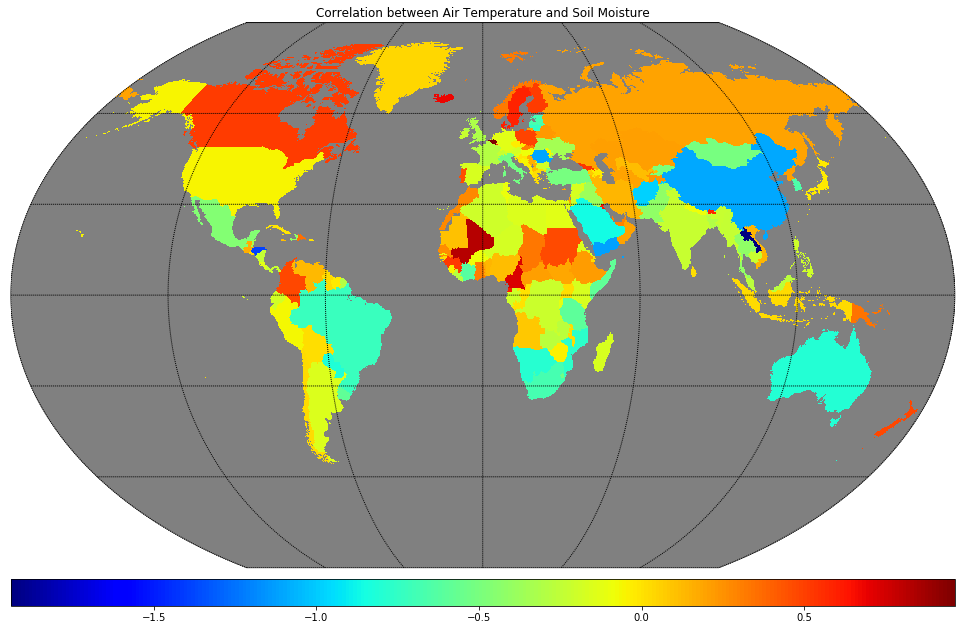

In [12]:
plot_2d(selected_var_array=air_temp_soil_moisture_corr_med, title='Correlation between Air Temperature and Soil Moisture')

### See the discrepancies between the two methods

(<matplotlib.figure.Figure at 0x7f9dce8842b0>,
 <mpl_toolkits.basemap.Basemap at 0x7f9dce617a20>)

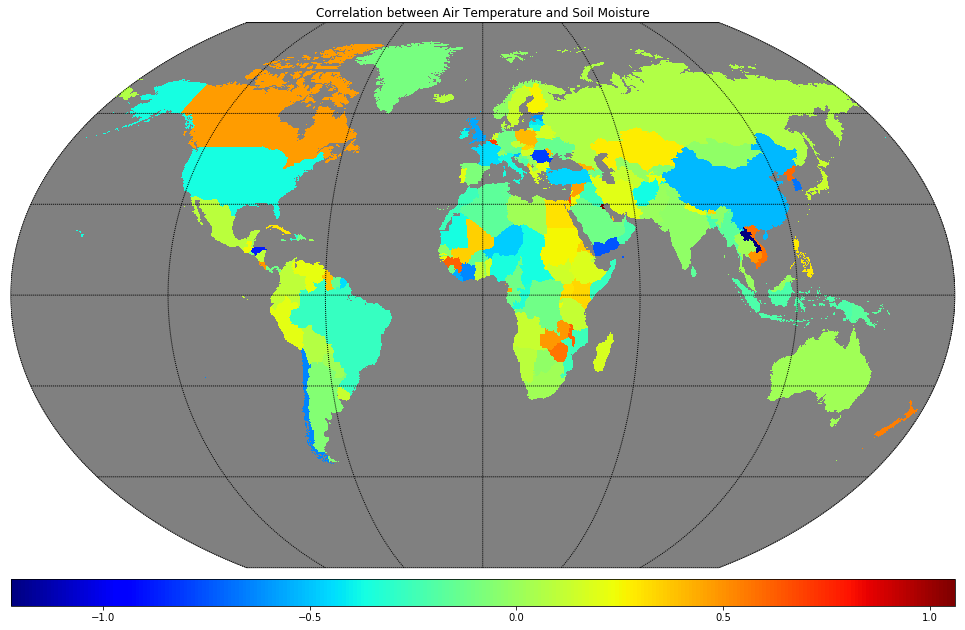

In [13]:
diff = air_temp_soil_moisture_corr_med - air_temp_soil_moisture_corr
plot_2d(selected_var_array=diff, title='Correlation between Air Temperature and Soil Moisture')

### Calculate Correlation Coefficient between two variables (per pixel operation)

Create functions to calculate correlation coefficient (both the classical and the more robust ways) as well as to display the results

In [14]:
def plot_correlation(ds, var1='ozone', var2='evaporation', method='standard'):
    correlation = corr(ds, var1, var2, method)
    if correlation is not None:
        correlation.plot.imshow(vmin = -1., vmax = 1., figsize=(18, 9))

def corr(ds, var1, var2, method):
    if not isinstance(ds, xr.Dataset):
        print('Input object ',ds,' is no xarray Dataset!')
        return None

    if method == 'corr_med':
        return _get_corr_med(ds, var1, var2)
    elif method == 'standard':
        return _get_corr(ds, var1, var2)
    else:
        return None

def _get_corr(ds, var1, var2):
    ds_tmean = ds.mean(skipna=True, dim = 'time')
    ds_tstd =  ds.std(skipna=True, dim = 'time')
    covar_1 = (ds[var1] - ds_tmean[var1])*(ds[var2] - ds_tmean[var2])
    return covar_1.mean(dim= 'time', skipna=True)/(ds_tstd[var1]*ds_tstd[var2])

def _get_corr_med(ds, var1, var2):
    ds_var1 = ds[var1]
    ds_var2 = ds[var2]
    ds_var1_med = ds_var1.compute().quantile(0.5, dim = 'time')
    ds_var2_med = ds_var2.compute().quantile(0.5, dim = 'time')
    MADx = (np.abs(ds_var1 - ds_var1_med)).compute().quantile(0.5, dim="time")
    MADy = (np.abs(ds_var2 - ds_var2_med)).compute().quantile(0.5, dim="time")
    return ((ds_var1 - ds_var1_med) * (ds_var2 - ds_var2_med)).compute().quantile(0.5, dim="time") / (MADx * MADy)

    

Select an area of interest to speed up the processing.

In [15]:
ESDC_Europe = ESDC.sel(lat = slice(70.,30.), lon = slice(-20.,35.))

In [16]:
var_names = []
for var_name in ESDC.data_vars:
    var_names.append(var_name)

Run **plot_correlation** function to allow interactive plotting. Note that this is a rather heavy computation, so it will take some seconds before the plot is updated.

In [17]:
interact(plot_correlation, ds=fixed(ESDC_Europe), var1=var_names, var2=var_names, method=fixed('standard'))

interactive(children=(Dropdown(description='var1', index=20, options=('aerosol_optical_thickness_1610', 'aeros…

<function __main__.plot_correlation(ds, var1='ozone', var2='evaporation', method='standard')>

Now plot the correlation with a more robust method.

In [18]:
interact(plot_correlation, ds=fixed(ESDC_Europe), var1=var_names, var2=var_names, method=fixed('corr_med'))

interactive(children=(Dropdown(description='var1', index=20, options=('aerosol_optical_thickness_1610', 'aeros…

<function __main__.plot_correlation(ds, var1='ozone', var2='evaporation', method='standard')>

And finally, see the difference between those two

In [19]:
diff = corr(ESDC_Europe, 'air_temperature_2m', 'evaporation', 'corr_med') - corr(ESDC_Europe, 'air_temperature_2m', 'evaporation', 'standard')

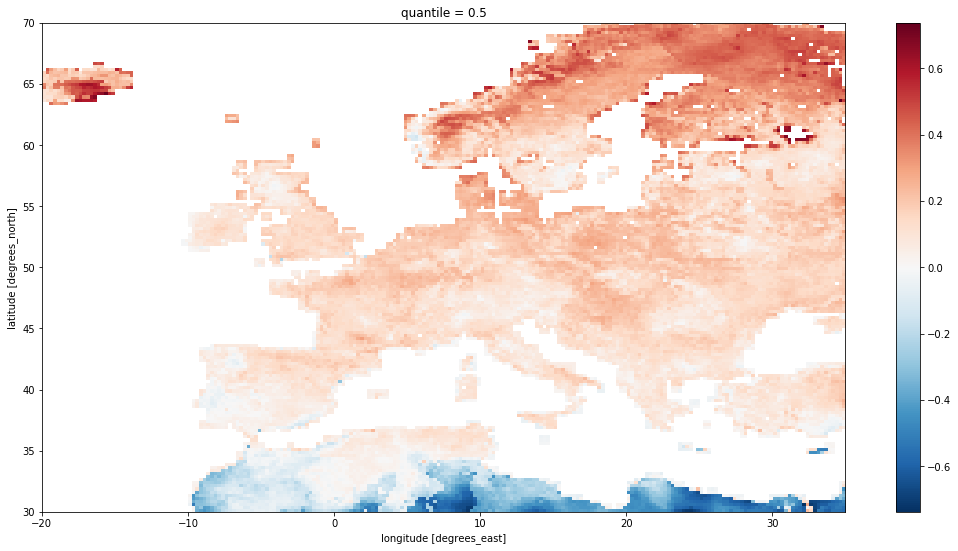

In [20]:
diff.plot.imshow(figsize=(18, 9))